In [1]:
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
def interquartileRule(data):
    # Calculate the first quartile (Q1)
    Q1 = np.percentile(data, 25)

    # Calculate the third quartile (Q3)
    Q3 = np.percentile(data, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the upper and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [3]:
def comparativeBoxplot(testPreDf, testPostDf, validationDf):
    # Create a figure and axis
    fig, ax = plt.subplots()

    plt.title("Comparative boxplot of the reconstruction MSE error")
    # Plot the first distribution as a boxplot
    bp1 = ax.boxplot(testPreDf.errors, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue'))

    # Plot the second distribution as a boxplot
    bp2 = ax.boxplot(testPostDf.errors, positions=[2], patch_artist=True, boxprops=dict(facecolor='red'))

    # Plot the third distribution as a boxplot
    bp3 = ax.boxplot(validationDf.errors, positions=[3], patch_artist=True, boxprops=dict(facecolor='green'))

    # Add a legend
    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['preIntervention', 'postIntervention', "validation"])

    plt.ylim(0,0.5)
    # Show the plot
    plt.show()

In [4]:
path = "./INSIST_small/INSISTevaluator_small/"
testPost = []
testPre = []
validation = []
for file in os.listdir("./INSIST_small/INSISTevaluator_small/"):
    df = pd.read_csv(path + file)
    if "Pre" in file:
        testPre.append(df)
    elif "Post" in file:
        testPost.append(df)
    elif "validation" in file:
        validation.append(df)

testPostDf = pd.concat(testPost).drop(columns=["Unnamed: 0"])
testPreDf = pd.concat(testPre).drop(columns=["Unnamed: 0"])
validationDf = pd.concat(validation).drop(columns=["Unnamed: 0"])

In [5]:
testPostDf.shape, testPreDf.shape, validationDf.shape

((163562, 2), (248501, 2), (143096, 2))

In [6]:
testPostDf.sort_values("dates", inplace=True)
testPostDf.reset_index(drop=True, inplace=True)

testPreDf.sort_values("dates", inplace=True)
testPreDf.reset_index(drop=True, inplace=True)

validationDf.sort_values("dates", inplace=True)
validationDf.reset_index(drop=True, inplace=True)

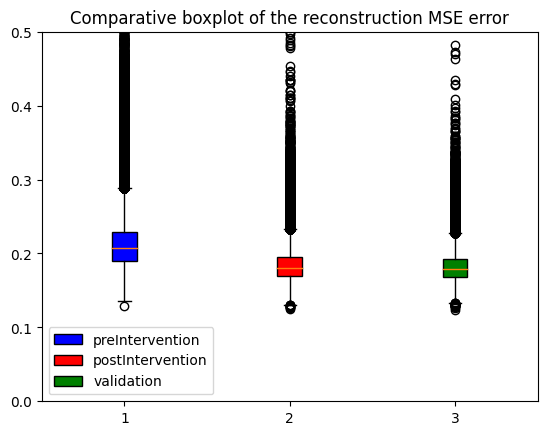

In [7]:
comparativeBoxplot(testPreDf, testPostDf, validationDf)

In [8]:
def dropOutliers(df):
    outliers = df.shape[0]
    lower_bound, upper_bound = interquartileRule(df.errors)
    newDf = df[(df["errors"]>lower_bound)&(df["errors"]<upper_bound)]
    print(f"outliers dropped: {outliers - newDf.shape[0]}")
    return newDf

In [9]:
validationDf = dropOutliers(validationDf)

outliers dropped: 4629


In [10]:
testPreDf = dropOutliers(testPreDf)

outliers dropped: 9604


In [11]:
testPostDf = dropOutliers(testPostDf)

outliers dropped: 6596


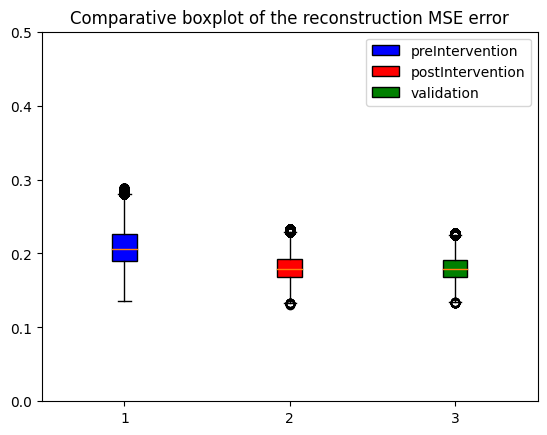

In [12]:
comparativeBoxplot(testPreDf, testPostDf, validationDf)

### Thresholds definition

In [13]:
valMean = validationDf["errors"].mean()
valStd = validationDf["errors"].std()

In [14]:
valMean + valStd

0.1968236089140605

In [15]:
testPreDf["anomaly"] = True
testPostDf["anomaly"] = False

testDF = pd.concat([testPreDf, testPostDf])
testDF

,dates,errors,anomaly
0,2019-04-30 22:00:32.910,0.202343,True
1,2019-04-30 22:00:33.910,0.171596,True
2,2019-04-30 22:00:34.910,0.198365,True
3,2019-04-30 22:00:35.910,0.222319,True
4,2019-04-30 22:00:36.910,0.205949,True
...,...,...,...
163557,2019-06-04 19:30:15.564,0.189366,False
163558,2019-06-04 19:30:31.564,0.189688,False
163559,2019-06-04 19:30:32.564,0.180373,False
163560,2019-06-04 19:30:33.564,0.206018,False


In [16]:
testDF["anomaly"].value_counts()

True     238897
False    156966
Name: anomaly, dtype: int64

In [17]:
def statisticsProvider(threshold):
    testDF["prediction"] = testDF["errors"].apply(lambda x: x>threshold)
    y_true, y_pred = testDF["anomaly"], testDF["prediction"]
    acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(testDF["anomaly"], testDF["prediction"], labels=[True, False])
    tp, fn, fp, tn = conf_mat.ravel()

    scores =precision_recall_fscore_support(y_true, y_pred)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"Precision False: {scores[0][0]}, Precision True: {scores[0][1]}")
    print(f"recall False: {scores[1][0]}, recall True: {scores[1][1]}")
    print(f"fscore False: {scores[2][0]}, fscore True: {scores[2][1]}")
    print(f"accuracy: {acc}")
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['True', 'False'])

No moving window

Threshold 1

In [18]:
threshold1 = valMean + 3*valStd
threshold1

0.2302161561018291

Precision False: 0.45277891372504664, Precision True: 0.9833365968278833
recall False: 0.9945784437394085, recall True: 0.2102119323390415
fscore False: 0.6222708511456695, fscore True: 0.3463773463876924
accuracy: 0.5212257776048784
Sensitivity: 0.2102119323390415
Specificity: 0.9945784437394085


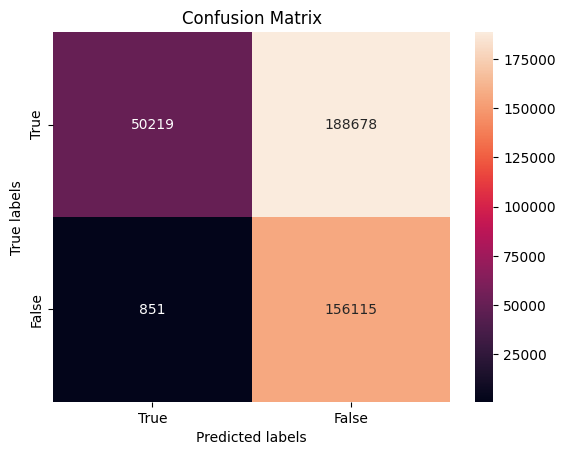

In [19]:
statisticsProvider(threshold1)

Threshold 2

In [20]:
threshold2 = valMean + 2.5*valStd
threshold2

0.22186801930488695

Precision False: 0.4733433324243251, Precision True: 0.9423237251766506
recall False: 0.9731151969216263, recall True: 0.2886055496720344
fscore False: 0.636890143476031, fscore True: 0.44187730721903196
accuracy: 0.5600245539492198
Sensitivity: 0.2886055496720344
Specificity: 0.9731151969216263


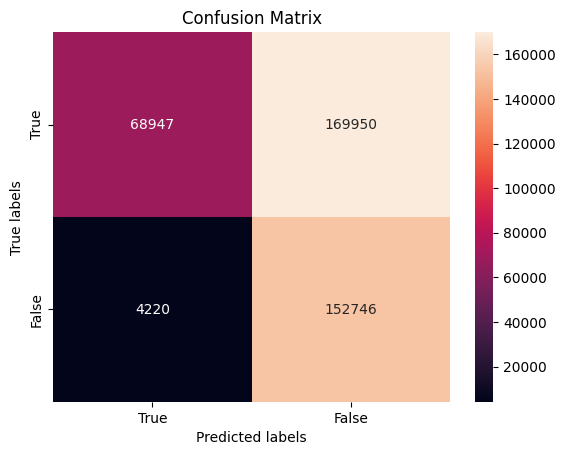

In [21]:
statisticsProvider(threshold2)

Threshold 3

In [22]:
threshold3 = valMean + 2*valStd
threshold3

0.2135198825079448

Precision False: 0.5016781373354984, Precision True: 0.9085122525593907
recall False: 0.9408470624211612, recall True: 0.385957127967283
fscore False: 0.6544113085478797, fscore True: 0.5417614120439737
accuracy: 0.6059798465630787
Sensitivity: 0.385957127967283
Specificity: 0.9408470624211612


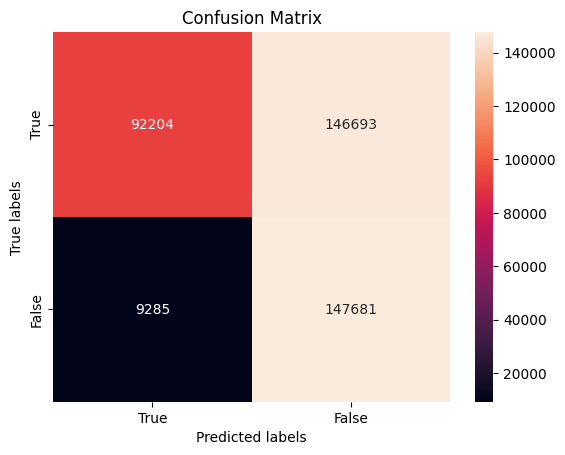

In [23]:
statisticsProvider(threshold3)

Threshold 4

In [24]:
data = testPostDf["errors"]
# Calculate the first quartile (Q1)
Q1 = np.percentile(data, 25)

# Calculate the third quartile (Q3)
Q3 = np.percentile(data, 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the upper and lower bounds
#lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Precision False: 0.4565703259685221, Precision True: 0.9727830955391006
recall False: 0.9903991947300689, recall True: 0.22546536792006597
fscore False: 0.6250123125724933, fscore True: 0.3660825033048218
accuracy: 0.5287738434761521
Sensitivity: 0.22546536792006597
Specificity: 0.9903991947300689


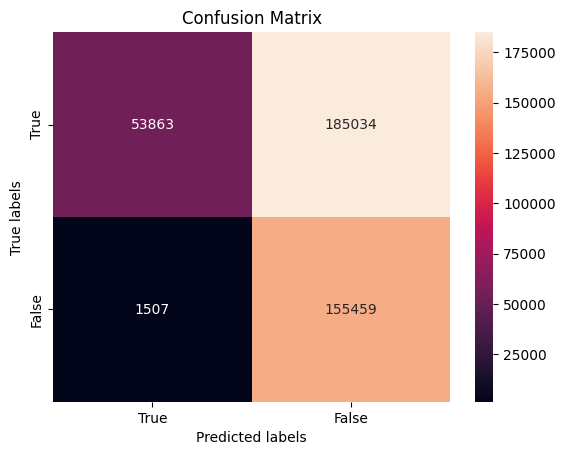

In [25]:
statisticsProvider(upper_bound)

In [26]:
def statisticsCalculator(df):
    y_true, y_pred = df["anomaly"], df["prediction"]
    acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(df["anomaly"], df["prediction"], labels=[True, False])
    tp, fn, fp, tn = conf_mat.ravel()

    #scores = precision_recall_fscore_support(y_true, y_pred)
    if (tp + fn) > 0:
        sensitivity = tp / (tp + fn)
    else:
        sensitivity = np.nan

    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
    else:
        specificity = np.nan

    return acc, sensitivity, specificity

In [27]:
windowSize = 100
accs = []
sensitivities = []
specificities = []
for index, row in tqdm(testDF.iterrows()):
    if index < windowSize-1:
        accs.append(np.nan)
        sensitivities.append(np.nan)
        specificities.append(np.nan)
        continue
    slice = testDF[index+1-windowSize:index+1]
    acc, sensitivity, specificity = statisticsCalculator(slice)
    accs.append(acc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

395863it [03:38, 1813.56it/s]


In [28]:
testDF["accuracy"] =  accs
testDF["sensitivity"] = sensitivities
testDF["specificity"] = specificities

testDF

,dates,errors,anomaly,prediction,accuracy,sensitivity,specificity
0,2019-04-30 22:00:32.910,0.202343,True,False,NaN,NaN,NaN
1,2019-04-30 22:00:33.910,0.171596,True,False,NaN,NaN,NaN
2,2019-04-30 22:00:34.910,0.198365,True,False,NaN,NaN,NaN
3,2019-04-30 22:00:35.910,0.222319,True,False,NaN,NaN,NaN
4,2019-04-30 22:00:36.910,0.205949,True,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...
163557,2019-06-04 19:30:15.564,0.189366,False,False,0.3,0.3,NaN
163558,2019-06-04 19:30:31.564,0.189688,False,False,0.3,0.3,NaN
163559,2019-06-04 19:30:32.564,0.180373,False,False,0.3,0.3,NaN
163560,2019-06-04 19:30:33.564,0.206018,False,False,0.3,0.3,NaN


In [31]:
testDF.reset_index(inplace=True, drop=True)
testDF.reset_index(inplace=True)


In [32]:
testDF

,level_0,index,dates,errors,anomaly,prediction,accuracy,sensitivity,specificity
0,0,0,2019-04-30 22:00:32.910,0.202343,True,False,NaN,NaN,NaN
1,1,1,2019-04-30 22:00:33.910,0.171596,True,False,NaN,NaN,NaN
2,2,2,2019-04-30 22:00:34.910,0.198365,True,False,NaN,NaN,NaN
3,3,3,2019-04-30 22:00:35.910,0.222319,True,False,NaN,NaN,NaN
4,4,4,2019-04-30 22:00:36.910,0.205949,True,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
395858,395858,395858,2019-06-04 19:30:15.564,0.189366,False,False,0.3,0.3,NaN
395859,395859,395859,2019-06-04 19:30:31.564,0.189688,False,False,0.3,0.3,NaN
395860,395860,395860,2019-06-04 19:30:32.564,0.180373,False,False,0.3,0.3,NaN
395861,395861,395861,2019-06-04 19:30:33.564,0.206018,False,False,0.3,0.3,NaN


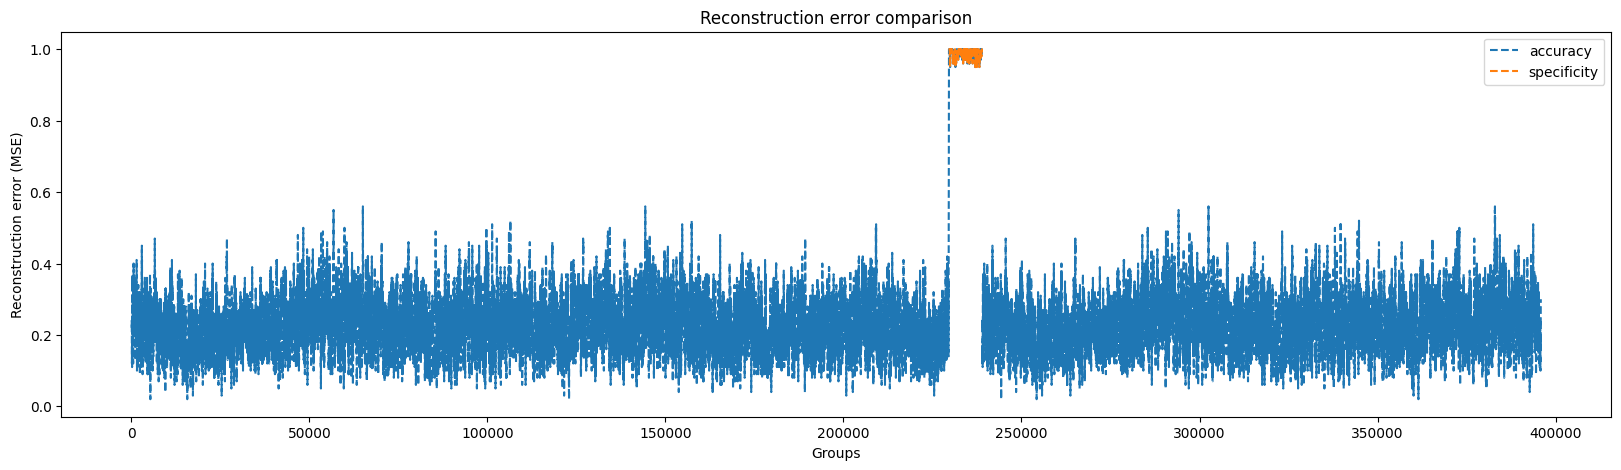

In [35]:
plt.figure(figsize=(20,5))
plt.plot(testDF["index"], testDF["accuracy"], label='accuracy', linestyle="dashed")
#plt.plot(testDF["index"],testDF["sensitivity"], label='sensitivity', linestyle="dashed")
plt.plot(testDF["index"],testDF["specificity"], label='specificity', linestyle="dashed")
plt.legend()
plt.xlabel('Groups')
plt.ylabel('Reconstruction error (MSE)')
plt.title('Reconstruction error comparison')

plt.show()

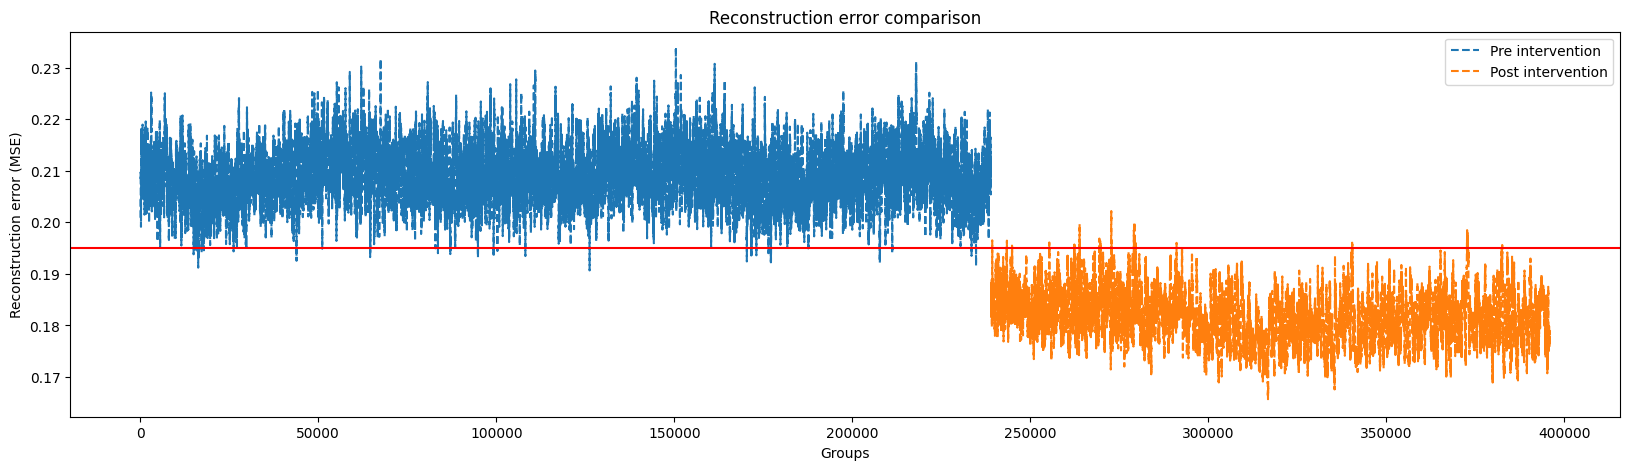

In [ ]:
index0 = testPreDf["errorAvg"].shape[0]
index1 = index0 + testPostDf["errorAvg"].shape[0]

plt.figure(figsize=(20,5))
plt.plot(range(0, index0), testPreDf["errorAvg"], label='Pre intervention', linestyle="dashed")
plt.plot(range(index0, index1),testPostDf["errorAvg"], label='Post intervention', linestyle="dashed")
plt.legend()
plt.axhline(0.195, color='r')
plt.xlabel('Groups')
plt.ylabel('Reconstruction error (MSE)')
plt.title('Reconstruction error comparison')

plt.show()